# Three-hinged arche, finding the worst loading case

This notebook aims to find the worst positionning of the snow load on an specific three-hinged arch.

We needed an angle on te very top of our arche, it is controlled by the global variable `k0 = 1.08875` but a perfect parabola will form with `k0=1.0`.

- Code:

  - The [Geometry](#Geometry-definition) section contains what defines the shape of the arche and the equivalent rectagular cross-section.

  - [Load functions](#Load-Functions) is where the external actions are defined. The intensities as well as the distributions are controlled from that part of the code. The dead load is dependent on the cross-section defined before.
  - [Solving](#System-solving-function) is where the statics comes in. An infinitely rigid system by computing a first-order solution. The `solve()` function begins by developping key variables such as the norm of the loads acting on each side (`F1` and `F2`) and their product with their respective centroids (`F1_c1` and `F2_c2`). As the sytem is isostatic, the reactions are foud by solving the equilibrium equations with python's `numpy.linalg.solve` function. The moment diagram is then computed from those reactions. Most of its output leaks though `global` variables but it returns the maximal moment. This makes it a good objective function to maximize.
  - The results can be visualized thanks to the `diagram()` function in the [plotting](#Plotting-results,-finding-the-worst-case-with-a-widget) section.

  - [Finding the worst case scenario](#Finding-the-worst-case-scenario-with-numerical-optimization) makes use of the scipy library to maximize the greatest moment by positionning the snow load efectively.

- Plots:

  - Anything under the [Diagram for worst case scenario](#Diagram-for-worst-case-scenario) markdown will give more information concerning the final solution.

## Imports

In [1]:
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import animation as anim
import ipywidgets as widgets
from scipy.optimize import minimize,LinearConstraint
#from IPython.display import display

l = 10000

# plt.rcParams["font.size"]=20
# plt.rcParams["figure.figsize"]=(10,10)

# Geometry definition of arches

In [2]:
# Arche
L = 7.5
H = 5.0
k0 = 1.08875

parabola   = lambda x, k=k0 : x*(k*L-x)*4/(L*(2*k*L-L))*H
para_deriv = lambda x, k=k0 : (k*L-2*x)*4/(L*(2*k*L-L))*H

def arches(x_input,k=k0):
    x = x_input.copy()
    x[x>L/2] = L-x[x>L/2]
    return parabola(x)

def deriv(x_input,k=k0):
    x = x_input[x_input<=L/2]
    x_= x_input[x_input>L/2]
    d = para_deriv(x)
    d = np.concatenate((d,-d[::-1][:min(len(x_),len(x))]))
    return d

# Load Functions and section geometry

In [3]:
# Section
thickness = 1
width  = 1
density = 5.28

max_concrete_width = 4.0 # m
light_concrete_density = 1.0*density
light_concrete_thickness = 0.2 # m

### Load functions ###

# ext load
S = 15 # m^2
q1 = 27.5 # snow
q2 = density # light concrete
Lmax = 4.0 # m

def vert_load(x,xmin=0,xmax=L):

    load = np.zeros_like(x)
    load[(x>=xmin) & (x<=xmax)] = q1
    
    return load

def light_concrete_load(d):

    thk = light_concrete_thickness # m
    wth = np.linspace(0,max_concrete_width,l) # m
    dns = light_concrete_density
    
    return dead_load(d,dns,thk,wth)
    
    
def dead_load(d,density,thickness,width):
    
    deriv_norm = np.sqrt(d**2+1)
    
    load = deriv_norm*density*thickness*width
    
    return load

def total_load(x,d,xmin=0,xmax=L):
    return vert_load(x,xmin,xmax) + dead_load(d,density,thickness,width) + light_concrete_load(d)
### End load functions ###

# System solving function

In [4]:
### Simple integration function 
def integrate(x,y, r0=0):
    # basic integration function
    l = len(x)
    I = np.zeros_like(x)
    I[0] = r0
    
    for i in range(1,l):
        dx = x[i]-x[i-1]
        y_ = (y[i]+y[i-1])/2
        I[i] = I[i-1] + dx*y_
    
    return I


def solve(xs):
    
    xmin = xs[0]
    xmax = xs[1]

    if xmin>xmax-0.1:
        xmin = xmax-0.1

    global x, y, d, load, moment
    global Ax, Ay, Bx, By, Cx, Cy

    x = np.linspace(0,L,l)
    d = deriv(x)
    load = total_load(x,d,xmin,xmax)
    F = np.trapz(load,x)


    ### Defining loads
    # Left arch
    x1 = x[x<=L/2]
    d1 = d[x<=L/2]
    p1 = load[x<=L/2]
    F1 =    np.trapz(p1   , x=x1)
    F1_c1 = np.trapz(p1*x1, x=x1)

    # Right arch
    x2 = x[x>L/2]
    d2 = d[x>L/2]
    p2 = load[x>L/2]
    F2 =    np.trapz(p2   , x=x2)
    F2_c2 = np.trapz(p2*x2, x=x2)


    ### Solving equilibrium
    ### For reactions
    A = np.array([
        [1, 0, -1,   0, 0, 0],
        [1, 0,  0,   0,-1, 0],
        [0, 1,  0,   1, 0, 0],
        [0, 1,  0,   0, 0, 1],
        [0, 0,  H, L/2, 0, 0],
        [0, 0,  H,-L/2, 0, 0],
    ])

    b = np.array([0, 0, F1, F, F1_c1, F2*L-F2_c2])

    solution = np.linalg.solve(A,b)
    Ax, Ay, Bx, By, Cx, Cy = solution

    ### Calculating momment from rections
    # Left side
    F1s = integrate(x1,p1)
    F1s_c1s = integrate(x1,p1*x1)

    M1  = -x1*F1s+F1s_c1s - Ax*arches(x1) + Ay*x1

    #right side
    F2s = integrate(x2,p2)
    F2s_c2s = integrate(x2,p2*x2)

    M2  = -(F2s*x2-F2s_c2s)-By*(x2-L/2)+Bx*(H-arches(x2))

    moment = np.concatenate((M1,M2))
    x = np.concatenate((x1,x2))
    y = arches(x)
    #plt.ylim(0,L/2*1.2)
    
    if xmin>=xmax-0.1:
        print(f"xminl too close or superior to xmax")
        print("xminl <- xmaxl-0.1")
        print()
    
    return np.max(np.abs(moment))

# Plotting results, finding the worst case with a widget

In [5]:
def diagram(xminl=0,xmaxl=L,display_diagram=True):

    solve([xminl,xmaxl])
    
    print(f"Extreme moments          : {np.max(moment), np.min(moment)}")
    print(f"Extreme moments position : {x[np.argmax(moment)], x[np.argmin(moment)]}")
    print(f"M_max = {max(np.abs(moment))}")
    
    if display_diagram:
        plt.figure(1)
        plt.figure(1).clear()
        plt.plot(x,y,"b",linewidth=4,label="Arches")
        plt.scatter([0,L/2,L],[0,H,0],facecolors="w",color="b",s=100,zorder=3,label="Articulations")

        x_load = x[load!=0]
        p_load = load[load!=0]
        xmin = x_load[0]
        xmax = x_load[-1]

        k=10
        h = H+0.5+abs(min(load))/k

        plt.plot(x_load,h + p_load/k,"r",label="Total load")
        plt.fill_between(x_load,h+np.zeros_like(x_load),h+p_load/k,color="r",alpha=0.1)
        for i in range(len(p_load))[::999]:
            plt.arrow(x_load[i],h+p_load[i]/k,0,-p_load[i]/k,color="r",width = 0.05)

        vectors = np.array([d,-np.ones_like(x)])
        n = vectors/np.linalg.norm(vectors.T,axis=1)

        scale = 0.1
        mx = x + n[0]*moment*scale
        my = y + n[1]*moment*scale

        plt.plot(mx,my,":g",label="Moment",linewidth=2)

        for i in range(len(moment))[::10]:
            plt.plot([x[i],mx[i]],[y[i],my[i]],"g",alpha=0.02,linewidth=6)

        plt.xlabel("x [m]")
        plt.ylabel("z [m]")
        plt.title(f"Moment diagram")
        plt.legend(loc=(1.05,0))
        # plt.savefig("Moment diagram")
        plt.show()
    
    return 

Extreme moments          : (17.294921114747865, 0.0)
Extreme moments position : (5.915091509150915, 0.0)
M_max = 17.294921114747865


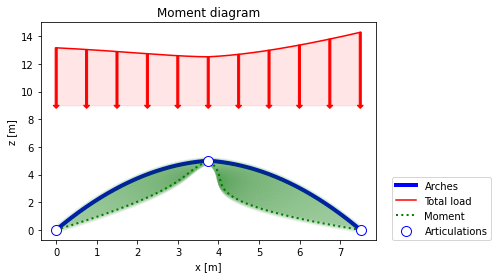

In [6]:
diagram()

In [7]:
widg = widgets.interact(diagram,xminl=(0,L,0.1),xmaxl=(0,L,0.1));

interactive(children=(FloatSlider(value=0.0, description='xminl', max=7.5), FloatSlider(value=7.5, description…

# Finding the worst case scenario with numerical optimization

In [8]:
A = np.array([
    [1, 0],
    [0, 1],
    [-1,1]
])
lb = [0,0,0.11]
ub = [L,L,L]
cntrs = LinearConstraint(A, lb, ub)
x0 = [0,L]
solution = minimize(lambda x: -solve(x),x0,constraints = cntrs)

n_opt = 5
x01s = np.linspace(4.5,L-0.11,n_opt)

f = widgets.IntProgress(min=0, max=n_opt**2) # instantiate the bar
display(f) # display the bar

for x01 in x01s:
    x02s = np.linspace(x01+0.11,L,n_opt)
    for x02 in x02s:
        x0 = [x01,x02]
        solution_ = minimize(lambda x: -solve(x),x0,constraints = cntrs)
        if solution_.fun < solution.fun:
            solution = solution_
        f.value += 1
        f.description = str(solution.fun)
solution

IntProgress(value=0, max=25)

     fun: -41.38802485166923
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([4.5, 7.5])

# Diagram for worst case scenario

Extreme moments          : (41.38802485166923, -10.504147705875681)
Extreme moments position : (5.818331833183318, 2.0679567956795677)
M_max = 41.38802485166923


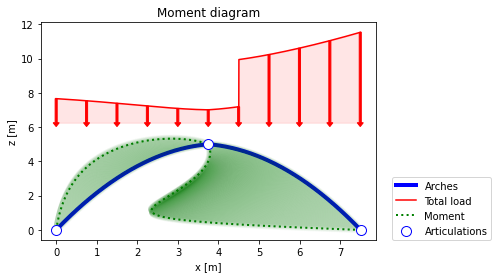

In [9]:
diagram(solution.x[0],solution.x[1])

# Other values

In [10]:
(Ax,Ay)

(27.285015009845335, 58.472902313665514)

In [11]:
(Bx,By)

(27.285015009845335, -18.739770465910098)

In [12]:
(Cx,Cy)

(27.285015009845335, 119.37878356502962)

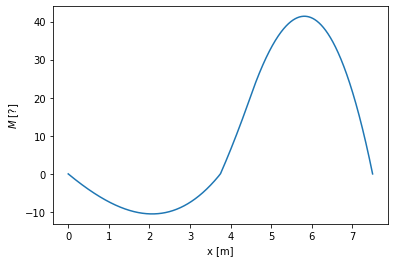

In [13]:
plt.figure()
plt.plot(x,moment)
plt.xlabel("x [m]")
plt.ylabel(r"$M$ [?]")
plt.show()

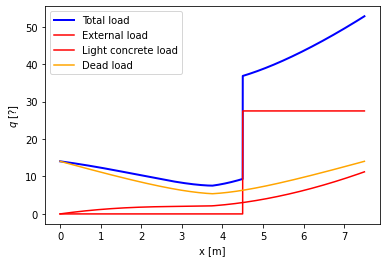

In [14]:
plt.figure()
plt.plot(x,load,"b", label = "Total load",zorder=0,linewidth=2)
plt.plot(x,vert_load(x,solution.x[0],solution.x[1]),color="r",label = "External load",zorder=1)
plt.plot(x,light_concrete_load(d),color="r",label = "Light concrete load",zorder=1)
plt.plot(x,dead_load(d,density,thickness,width),color="orange", label = "Dead load",zorder=2)
plt.legend()
plt.xlabel("x [m]")
plt.ylabel(r"$q$ [?]")
plt.show()

NameError: ignored

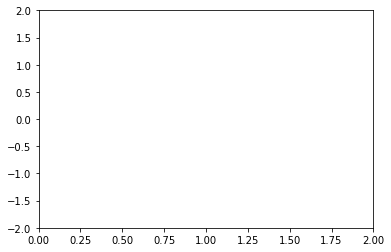

In [15]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as anim

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()